<a href="https://colab.research.google.com/github/PadmarajBhat/Machine-Learning/blob/master/BrainTumorClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Revisiting the old capstone project with TF2.0

Dataset is hyp5: This data has to be placed in google drive so as to be usable in colab.

In [0]:
import os
import zipfile
import h5py
import numpy as np
from matplotlib import pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!ls /content/drive/'My Drive'/1512427

brainTumorDataPublic_1533-2298.zip  brainTumorDataPublic_767-1532.zip
brainTumorDataPublic_1-766.zip	    cvind.mat
brainTumorDataPublic_2299-3064.zip  README.txt


In [5]:
!ls /content/drive/'My Drive'/1512427/brainTumorDataPublic_1-766.zip

'/content/drive/My Drive/1512427/brainTumorDataPublic_1-766.zip'


In [0]:
def return_imageInfo_from_mat_file(file_name):
    f = h5py.File(file_name,'r')
    return np.array(f['cjdata']['image']), np.array(f['cjdata']['label'],np.int)
    



1.mat 268680 b'MATLAB 7.3'
10.mat 243552 b'MATLAB 7.3'
100.mat 290650 b'MATLAB 7.3'
101.mat 286485 b'MATLAB 7.3'
102.mat 287254 b'MATLAB 7.3'


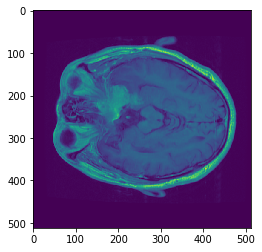

103.mat 284243 b'MATLAB 7.3'
104.mat 265318 b'MATLAB 7.3'
105.mat 265289 b'MATLAB 7.3'
106.mat 262580 b'MATLAB 7.3'
107.mat 259420 b'MATLAB 7.3'
108.mat 256550 b'MATLAB 7.3'
109.mat 251086 b'MATLAB 7.3'
11.mat 244110 b'MATLAB 7.3'


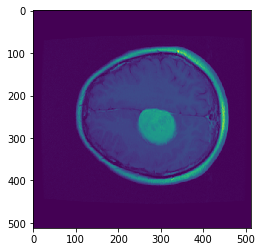

110.mat 247594 b'MATLAB 7.3'
111.mat 278018 b'MATLAB 7.3'
112.mat 277757 b'MATLAB 7.3'
113.mat 250402 b'MATLAB 7.3'
114.mat 245461 b'MATLAB 7.3'
115.mat 255473 b'MATLAB 7.3'
116.mat 254062 b'MATLAB 7.3'
117.mat 251141 b'MATLAB 7.3'
118.mat 246482 b'MATLAB 7.3'


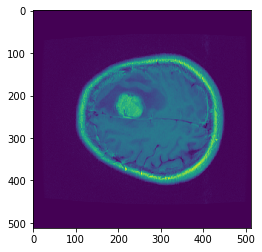

119.mat 256976 b'MATLAB 7.3'
12.mat 242510 b'MATLAB 7.3'
120.mat 270309 b'MATLAB 7.3'
121.mat 267036 b'MATLAB 7.3'
122.mat 266892 b'MATLAB 7.3'
123.mat 267268 b'MATLAB 7.3'
124.mat 287781 b'MATLAB 7.3'
125.mat 267098 b'MATLAB 7.3'
126.mat 266418 b'MATLAB 7.3'
127.mat 261989 b'MATLAB 7.3'
128.mat 268560 b'MATLAB 7.3'
129.mat 268792 b'MATLAB 7.3'
13.mat 238933 b'MATLAB 7.3'
130.mat 267961 b'MATLAB 7.3'
131.mat 268457 b'MATLAB 7.3'


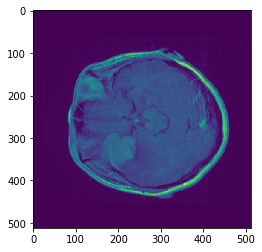

132.mat 244454 b'MATLAB 7.3'
133.mat 240834 b'MATLAB 7.3'
134.mat 233356 b'MATLAB 7.3'
135.mat 271849 b'MATLAB 7.3'
136.mat 269209 b'MATLAB 7.3'
137.mat 265670 b'MATLAB 7.3'
138.mat 260527 b'MATLAB 7.3'
139.mat 238076 b'MATLAB 7.3'
14.mat 232343 b'MATLAB 7.3'
140.mat 232197 b'MATLAB 7.3'
141.mat 224394 b'MATLAB 7.3'
142.mat 246711 b'MATLAB 7.3'
143.mat 242394 b'MATLAB 7.3'
144.mat 275488 b'MATLAB 7.3'
145.mat 273602 b'MATLAB 7.3'
146.mat 273331 b'MATLAB 7.3'
147.mat 271356 b'MATLAB 7.3'
148.mat 269802 b'MATLAB 7.3'
149.mat 266055 b'MATLAB 7.3'


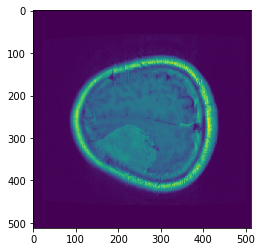

15.mat 226698 b'MATLAB 7.3'
150.mat 263076 b'MATLAB 7.3'
151.mat 290526 b'MATLAB 7.3'
152.mat 289474 b'MATLAB 7.3'
153.mat 288530 b'MATLAB 7.3'
154.mat 264118 b'MATLAB 7.3'
155.mat 262966 b'MATLAB 7.3'
156.mat 260944 b'MATLAB 7.3'
157.mat 256093 b'MATLAB 7.3'
158.mat 250654 b'MATLAB 7.3'


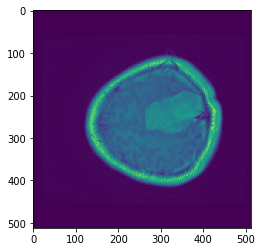

159.mat 244876 b'MATLAB 7.3'
16.mat 262220 b'MATLAB 7.3'
160.mat 263554 b'MATLAB 7.3'
161.mat 262113 b'MATLAB 7.3'
162.mat 261410 b'MATLAB 7.3'
163.mat 264218 b'MATLAB 7.3'
164.mat 277354 b'MATLAB 7.3'
165.mat 272504 b'MATLAB 7.3'
166.mat 271342 b'MATLAB 7.3'
167.mat 272719 b'MATLAB 7.3'
168.mat 271613 b'MATLAB 7.3'
169.mat 260944 b'MATLAB 7.3'
17.mat 259842 b'MATLAB 7.3'
170.mat 258326 b'MATLAB 7.3'
171.mat 254468 b'MATLAB 7.3'
172.mat 251887 b'MATLAB 7.3'
173.mat 248128 b'MATLAB 7.3'
174.mat 244979 b'MATLAB 7.3'
175.mat 245930 b'MATLAB 7.3'
176.mat 246081 b'MATLAB 7.3'
177.mat 242791 b'MATLAB 7.3'
178.mat 238444 b'MATLAB 7.3'
179.mat 231442 b'MATLAB 7.3'
18.mat 257633 b'MATLAB 7.3'
180.mat 251959 b'MATLAB 7.3'
181.mat 250566 b'MATLAB 7.3'


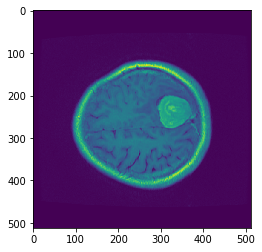

182.mat 248038 b'MATLAB 7.3'
183.mat 242408 b'MATLAB 7.3'
184.mat 272944 b'MATLAB 7.3'
185.mat 270501 b'MATLAB 7.3'
186.mat 267820 b'MATLAB 7.3'
187.mat 268172 b'MATLAB 7.3'
188.mat 267045 b'MATLAB 7.3'
189.mat 264735 b'MATLAB 7.3'
19.mat 257230 b'MATLAB 7.3'
190.mat 265375 b'MATLAB 7.3'
191.mat 264596 b'MATLAB 7.3'
192.mat 260346 b'MATLAB 7.3'


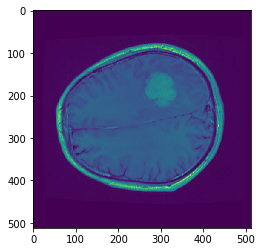

193.mat 260635 b'MATLAB 7.3'
194.mat 260553 b'MATLAB 7.3'
195.mat 257616 b'MATLAB 7.3'
196.mat 254188 b'MATLAB 7.3'
197.mat 248434 b'MATLAB 7.3'
198.mat 277010 b'MATLAB 7.3'
199.mat 277120 b'MATLAB 7.3'
2.mat 265333 b'MATLAB 7.3'
20.mat 263472 b'MATLAB 7.3'
200.mat 239347 b'MATLAB 7.3'
201.mat 236343 b'MATLAB 7.3'
202.mat 231226 b'MATLAB 7.3'
203.mat 256943 b'MATLAB 7.3'
204.mat 265980 b'MATLAB 7.3'
205.mat 262523 b'MATLAB 7.3'
206.mat 260853 b'MATLAB 7.3'
207.mat 256237 b'MATLAB 7.3'
208.mat 251255 b'MATLAB 7.3'
209.mat 276603 b'MATLAB 7.3'
21.mat 263307 b'MATLAB 7.3'
210.mat 277441 b'MATLAB 7.3'
211.mat 280044 b'MATLAB 7.3'
212.mat 283718 b'MATLAB 7.3'
213.mat 289352 b'MATLAB 7.3'
214.mat 295810 b'MATLAB 7.3'
215.mat 299536 b'MATLAB 7.3'
216.mat 300908 b'MATLAB 7.3'
217.mat 304511 b'MATLAB 7.3'
218.mat 318211 b'MATLAB 7.3'
219.mat 319372 b'MATLAB 7.3'
22.mat 260762 b'MATLAB 7.3'
220.mat 320306 b'MATLAB 7.3'
221.mat 278994 b'MATLAB 7.3'
222.mat 279633 b'MATLAB 7.3'
223.mat 276487 b'MA

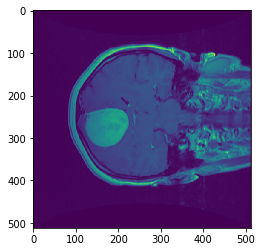

224.mat 277065 b'MATLAB 7.3'
225.mat 274559 b'MATLAB 7.3'
226.mat 272946 b'MATLAB 7.3'
227.mat 280321 b'MATLAB 7.3'
228.mat 283869 b'MATLAB 7.3'
229.mat 287481 b'MATLAB 7.3'
23.mat 256397 b'MATLAB 7.3'
230.mat 289702 b'MATLAB 7.3'
231.mat 303019 b'MATLAB 7.3'
232.mat 306814 b'MATLAB 7.3'
233.mat 309713 b'MATLAB 7.3'
234.mat 306124 b'MATLAB 7.3'
235.mat 304480 b'MATLAB 7.3'
236.mat 310536 b'MATLAB 7.3'
237.mat 310736 b'MATLAB 7.3'
238.mat 310930 b'MATLAB 7.3'
239.mat 289793 b'MATLAB 7.3'
24.mat 283867 b'MATLAB 7.3'
240.mat 277578 b'MATLAB 7.3'
241.mat 280204 b'MATLAB 7.3'
242.mat 288843 b'MATLAB 7.3'
243.mat 290774 b'MATLAB 7.3'
244.mat 293226 b'MATLAB 7.3'
245.mat 295166 b'MATLAB 7.3'
246.mat 342158 b'MATLAB 7.3'
247.mat 344168 b'MATLAB 7.3'
248.mat 344650 b'MATLAB 7.3'
249.mat 348397 b'MATLAB 7.3'
25.mat 283663 b'MATLAB 7.3'
250.mat 349549 b'MATLAB 7.3'
251.mat 352652 b'MATLAB 7.3'
252.mat 272684 b'MATLAB 7.3'
253.mat 294734 b'MATLAB 7.3'
254.mat 288135 b'MATLAB 7.3'
255.mat 289948 b'

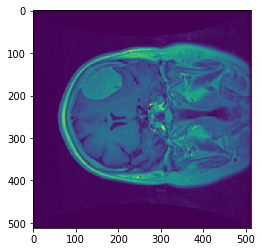

272.mat 316891 b'MATLAB 7.3'
273.mat 319012 b'MATLAB 7.3'
274.mat 319842 b'MATLAB 7.3'
275.mat 296534 b'MATLAB 7.3'
276.mat 300584 b'MATLAB 7.3'


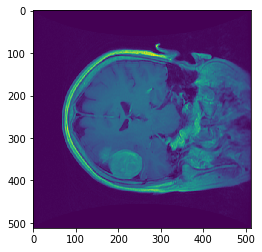

277.mat 304171 b'MATLAB 7.3'
278.mat 301637 b'MATLAB 7.3'
279.mat 300902 b'MATLAB 7.3'
28.mat 292345 b'MATLAB 7.3'
280.mat 295985 b'MATLAB 7.3'
281.mat 315144 b'MATLAB 7.3'
282.mat 315265 b'MATLAB 7.3'
283.mat 311474 b'MATLAB 7.3'
284.mat 317121 b'MATLAB 7.3'
285.mat 316670 b'MATLAB 7.3'
286.mat 316601 b'MATLAB 7.3'
287.mat 317430 b'MATLAB 7.3'
288.mat 322663 b'MATLAB 7.3'
289.mat 324482 b'MATLAB 7.3'
29.mat 288725 b'MATLAB 7.3'
290.mat 280721 b'MATLAB 7.3'
291.mat 287916 b'MATLAB 7.3'
292.mat 293855 b'MATLAB 7.3'
293.mat 299206 b'MATLAB 7.3'
294.mat 292204 b'MATLAB 7.3'
295.mat 286709 b'MATLAB 7.3'
296.mat 279409 b'MATLAB 7.3'
297.mat 301906 b'MATLAB 7.3'
298.mat 296119 b'MATLAB 7.3'
299.mat 281861 b'MATLAB 7.3'
3.mat 265968 b'MATLAB 7.3'
30.mat 285136 b'MATLAB 7.3'
300.mat 288996 b'MATLAB 7.3'
301.mat 291933 b'MATLAB 7.3'
302.mat 296689 b'MATLAB 7.3'
303.mat 298798 b'MATLAB 7.3'
304.mat 298678 b'MATLAB 7.3'


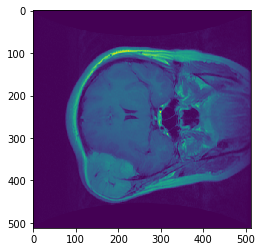

305.mat 300397 b'MATLAB 7.3'
306.mat 305648 b'MATLAB 7.3'
307.mat 305785 b'MATLAB 7.3'
308.mat 305586 b'MATLAB 7.3'
309.mat 305287 b'MATLAB 7.3'
31.mat 282342 b'MATLAB 7.3'
310.mat 302735 b'MATLAB 7.3'
311.mat 313149 b'MATLAB 7.3'
312.mat 309448 b'MATLAB 7.3'
313.mat 303518 b'MATLAB 7.3'
314.mat 296884 b'MATLAB 7.3'
315.mat 260071 b'MATLAB 7.3'
316.mat 287044 b'MATLAB 7.3'
317.mat 287442 b'MATLAB 7.3'
318.mat 286155 b'MATLAB 7.3'
319.mat 282570 b'MATLAB 7.3'
32.mat 279578 b'MATLAB 7.3'
320.mat 295849 b'MATLAB 7.3'
321.mat 299734 b'MATLAB 7.3'
322.mat 300639 b'MATLAB 7.3'
323.mat 304020 b'MATLAB 7.3'
324.mat 307568 b'MATLAB 7.3'
325.mat 308935 b'MATLAB 7.3'
326.mat 300030 b'MATLAB 7.3'
327.mat 302862 b'MATLAB 7.3'


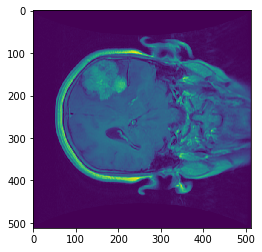

328.mat 302542 b'MATLAB 7.3'
329.mat 294665 b'MATLAB 7.3'
33.mat 278194 b'MATLAB 7.3'
330.mat 289073 b'MATLAB 7.3'
331.mat 285925 b'MATLAB 7.3'


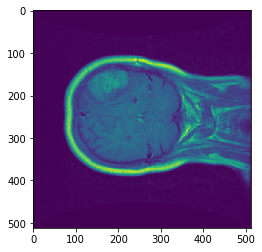

332.mat 292777 b'MATLAB 7.3'
333.mat 295577 b'MATLAB 7.3'
334.mat 283322 b'MATLAB 7.3'
335.mat 285712 b'MATLAB 7.3'
336.mat 281489 b'MATLAB 7.3'
337.mat 283704 b'MATLAB 7.3'
338.mat 286646 b'MATLAB 7.3'
339.mat 289480 b'MATLAB 7.3'
34.mat 258131 b'MATLAB 7.3'
340.mat 301140 b'MATLAB 7.3'
341.mat 295773 b'MATLAB 7.3'
342.mat 298158 b'MATLAB 7.3'
343.mat 298514 b'MATLAB 7.3'
344.mat 293406 b'MATLAB 7.3'
345.mat 334878 b'MATLAB 7.3'
346.mat 337997 b'MATLAB 7.3'
347.mat 338455 b'MATLAB 7.3'
348.mat 341710 b'MATLAB 7.3'
349.mat 310289 b'MATLAB 7.3'
35.mat 265580 b'MATLAB 7.3'
350.mat 314189 b'MATLAB 7.3'
351.mat 316417 b'MATLAB 7.3'
352.mat 315696 b'MATLAB 7.3'
353.mat 285102 b'MATLAB 7.3'
354.mat 291534 b'MATLAB 7.3'
355.mat 295574 b'MATLAB 7.3'
356.mat 298637 b'MATLAB 7.3'
357.mat 272994 b'MATLAB 7.3'
358.mat 278839 b'MATLAB 7.3'
359.mat 281227 b'MATLAB 7.3'
36.mat 280603 b'MATLAB 7.3'
360.mat 287900 b'MATLAB 7.3'
361.mat 288559 b'MATLAB 7.3'
362.mat 291471 b'MATLAB 7.3'
363.mat 296293 b'

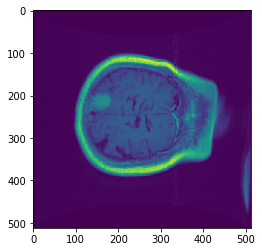

37.mat 281685 b'MATLAB 7.3'
370.mat 296124 b'MATLAB 7.3'
371.mat 301172 b'MATLAB 7.3'
372.mat 289672 b'MATLAB 7.3'
373.mat 294551 b'MATLAB 7.3'
374.mat 297220 b'MATLAB 7.3'
375.mat 299730 b'MATLAB 7.3'
376.mat 303557 b'MATLAB 7.3'
377.mat 307508 b'MATLAB 7.3'
378.mat 306746 b'MATLAB 7.3'
379.mat 307655 b'MATLAB 7.3'
38.mat 284106 b'MATLAB 7.3'
380.mat 306209 b'MATLAB 7.3'
381.mat 303261 b'MATLAB 7.3'
382.mat 294183 b'MATLAB 7.3'
383.mat 297967 b'MATLAB 7.3'
384.mat 299929 b'MATLAB 7.3'
385.mat 301457 b'MATLAB 7.3'


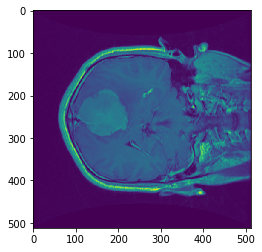

386.mat 300789 b'MATLAB 7.3'
387.mat 296806 b'MATLAB 7.3'
388.mat 292891 b'MATLAB 7.3'
389.mat 288246 b'MATLAB 7.3'
39.mat 284224 b'MATLAB 7.3'
390.mat 291771 b'MATLAB 7.3'
391.mat 294927 b'MATLAB 7.3'
392.mat 298478 b'MATLAB 7.3'
393.mat 276519 b'MATLAB 7.3'
394.mat 280123 b'MATLAB 7.3'
395.mat 307902 b'MATLAB 7.3'


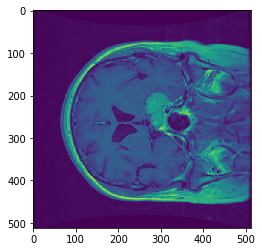

396.mat 313118 b'MATLAB 7.3'
397.mat 315251 b'MATLAB 7.3'
398.mat 313712 b'MATLAB 7.3'
399.mat 261837 b'MATLAB 7.3'
4.mat 265863 b'MATLAB 7.3'
40.mat 281065 b'MATLAB 7.3'
400.mat 266956 b'MATLAB 7.3'
401.mat 271074 b'MATLAB 7.3'
402.mat 275189 b'MATLAB 7.3'
403.mat 278655 b'MATLAB 7.3'
404.mat 281080 b'MATLAB 7.3'
405.mat 294832 b'MATLAB 7.3'
406.mat 290462 b'MATLAB 7.3'
407.mat 286035 b'MATLAB 7.3'
408.mat 313306 b'MATLAB 7.3'
409.mat 311546 b'MATLAB 7.3'
41.mat 280734 b'MATLAB 7.3'
410.mat 310491 b'MATLAB 7.3'
411.mat 307608 b'MATLAB 7.3'
412.mat 304914 b'MATLAB 7.3'
413.mat 299726 b'MATLAB 7.3'
414.mat 303860 b'MATLAB 7.3'
415.mat 304837 b'MATLAB 7.3'


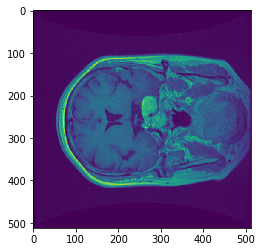

416.mat 306386 b'MATLAB 7.3'
417.mat 307715 b'MATLAB 7.3'
418.mat 294699 b'MATLAB 7.3'
419.mat 291507 b'MATLAB 7.3'
42.mat 278082 b'MATLAB 7.3'
420.mat 282310 b'MATLAB 7.3'
421.mat 270285 b'MATLAB 7.3'
422.mat 251827 b'MATLAB 7.3'
423.mat 298775 b'MATLAB 7.3'
424.mat 301497 b'MATLAB 7.3'
425.mat 305267 b'MATLAB 7.3'
426.mat 308027 b'MATLAB 7.3'
427.mat 304330 b'MATLAB 7.3'
428.mat 297822 b'MATLAB 7.3'
429.mat 292277 b'MATLAB 7.3'
43.mat 275959 b'MATLAB 7.3'
430.mat 300898 b'MATLAB 7.3'
431.mat 297654 b'MATLAB 7.3'
432.mat 294816 b'MATLAB 7.3'
433.mat 296267 b'MATLAB 7.3'
434.mat 297511 b'MATLAB 7.3'


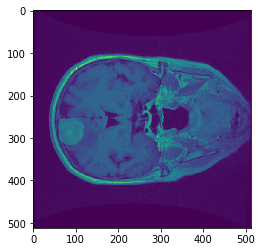

435.mat 299489 b'MATLAB 7.3'
436.mat 301604 b'MATLAB 7.3'
437.mat 290816 b'MATLAB 7.3'
438.mat 313424 b'MATLAB 7.3'
439.mat 310078 b'MATLAB 7.3'
44.mat 272132 b'MATLAB 7.3'
440.mat 307947 b'MATLAB 7.3'
441.mat 302573 b'MATLAB 7.3'
442.mat 315289 b'MATLAB 7.3'
443.mat 322660 b'MATLAB 7.3'
444.mat 327402 b'MATLAB 7.3'
445.mat 330328 b'MATLAB 7.3'
446.mat 330197 b'MATLAB 7.3'
447.mat 330585 b'MATLAB 7.3'
448.mat 368442 b'MATLAB 7.3'
449.mat 365563 b'MATLAB 7.3'
45.mat 279077 b'MATLAB 7.3'
450.mat 286438 b'MATLAB 7.3'
451.mat 290775 b'MATLAB 7.3'
452.mat 294078 b'MATLAB 7.3'
453.mat 296177 b'MATLAB 7.3'
454.mat 300179 b'MATLAB 7.3'
455.mat 319154 b'MATLAB 7.3'
456.mat 314464 b'MATLAB 7.3'
457.mat 311073 b'MATLAB 7.3'
458.mat 306278 b'MATLAB 7.3'


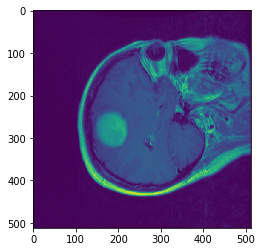

459.mat 286882 b'MATLAB 7.3'
46.mat 274563 b'MATLAB 7.3'
460.mat 291141 b'MATLAB 7.3'
461.mat 328308 b'MATLAB 7.3'
462.mat 332417 b'MATLAB 7.3'
463.mat 331938 b'MATLAB 7.3'
464.mat 327133 b'MATLAB 7.3'
465.mat 343367 b'MATLAB 7.3'
466.mat 347822 b'MATLAB 7.3'
467.mat 351331 b'MATLAB 7.3'
468.mat 347287 b'MATLAB 7.3'
469.mat 341923 b'MATLAB 7.3'
47.mat 271461 b'MATLAB 7.3'
470.mat 335383 b'MATLAB 7.3'
471.mat 287414 b'MATLAB 7.3'


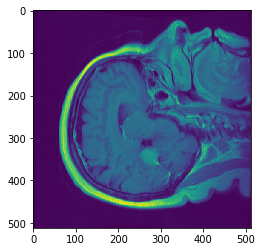

472.mat 293158 b'MATLAB 7.3'
473.mat 286762 b'MATLAB 7.3'


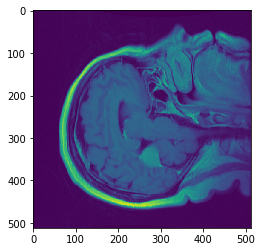

474.mat 350588 b'MATLAB 7.3'
475.mat 354319 b'MATLAB 7.3'
476.mat 327492 b'MATLAB 7.3'
477.mat 333236 b'MATLAB 7.3'
478.mat 310664 b'MATLAB 7.3'
479.mat 314562 b'MATLAB 7.3'
48.mat 266660 b'MATLAB 7.3'
480.mat 309889 b'MATLAB 7.3'
481.mat 320385 b'MATLAB 7.3'
482.mat 327644 b'MATLAB 7.3'
483.mat 330316 b'MATLAB 7.3'
484.mat 332291 b'MATLAB 7.3'
485.mat 274481 b'MATLAB 7.3'
486.mat 279265 b'MATLAB 7.3'
487.mat 283227 b'MATLAB 7.3'
488.mat 296144 b'MATLAB 7.3'
489.mat 334648 b'MATLAB 7.3'
49.mat 273303 b'MATLAB 7.3'
490.mat 269425 b'MATLAB 7.3'
491.mat 273776 b'MATLAB 7.3'
492.mat 277275 b'MATLAB 7.3'
493.mat 286505 b'MATLAB 7.3'
494.mat 290281 b'MATLAB 7.3'
495.mat 357536 b'MATLAB 7.3'
496.mat 306396 b'MATLAB 7.3'
497.mat 311579 b'MATLAB 7.3'
498.mat 316876 b'MATLAB 7.3'


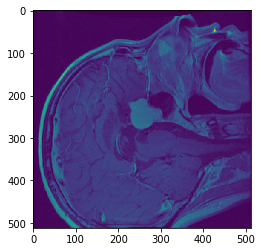

499.mat 316371 b'MATLAB 7.3'
5.mat 263788 b'MATLAB 7.3'
50.mat 274855 b'MATLAB 7.3'


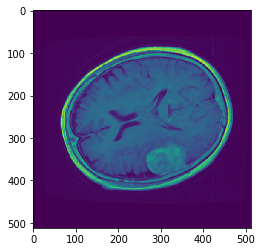

500.mat 306903 b'MATLAB 7.3'
501.mat 327743 b'MATLAB 7.3'
502.mat 322725 b'MATLAB 7.3'
503.mat 319685 b'MATLAB 7.3'
504.mat 315269 b'MATLAB 7.3'
505.mat 331662 b'MATLAB 7.3'
506.mat 341899 b'MATLAB 7.3'
507.mat 345673 b'MATLAB 7.3'
508.mat 349801 b'MATLAB 7.3'
509.mat 351034 b'MATLAB 7.3'
51.mat 271991 b'MATLAB 7.3'
510.mat 302514 b'MATLAB 7.3'
511.mat 320094 b'MATLAB 7.3'
512.mat 327986 b'MATLAB 7.3'
513.mat 331718 b'MATLAB 7.3'
514.mat 246024 b'MATLAB 7.3'
515.mat 251039 b'MATLAB 7.3'
516.mat 249157 b'MATLAB 7.3'
517.mat 328768 b'MATLAB 7.3'
518.mat 349450 b'MATLAB 7.3'
519.mat 340359 b'MATLAB 7.3'
52.mat 268238 b'MATLAB 7.3'
520.mat 361671 b'MATLAB 7.3'
521.mat 356367 b'MATLAB 7.3'
522.mat 353337 b'MATLAB 7.3'
523.mat 353051 b'MATLAB 7.3'
524.mat 347382 b'MATLAB 7.3'
525.mat 344806 b'MATLAB 7.3'
526.mat 338956 b'MATLAB 7.3'
527.mat 331723 b'MATLAB 7.3'
528.mat 342432 b'MATLAB 7.3'
529.mat 349592 b'MATLAB 7.3'
53.mat 265127 b'MATLAB 7.3'
530.mat 341422 b'MATLAB 7.3'
531.mat 336164 b'

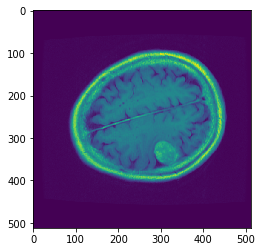

540.mat 260360 b'MATLAB 7.3'
541.mat 305280 b'MATLAB 7.3'
542.mat 311421 b'MATLAB 7.3'
543.mat 356116 b'MATLAB 7.3'
544.mat 355562 b'MATLAB 7.3'
545.mat 353020 b'MATLAB 7.3'
546.mat 350212 b'MATLAB 7.3'
547.mat 347681 b'MATLAB 7.3'
548.mat 345002 b'MATLAB 7.3'
549.mat 342103 b'MATLAB 7.3'
55.mat 256671 b'MATLAB 7.3'
550.mat 302797 b'MATLAB 7.3'
551.mat 318760 b'MATLAB 7.3'
552.mat 323063 b'MATLAB 7.3'
553.mat 328588 b'MATLAB 7.3'
554.mat 319039 b'MATLAB 7.3'
555.mat 316027 b'MATLAB 7.3'
556.mat 335095 b'MATLAB 7.3'
557.mat 340663 b'MATLAB 7.3'
558.mat 344382 b'MATLAB 7.3'
559.mat 349343 b'MATLAB 7.3'


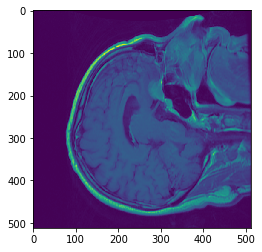

56.mat 276262 b'MATLAB 7.3'
560.mat 252745 b'MATLAB 7.3'
561.mat 264000 b'MATLAB 7.3'
562.mat 271478 b'MATLAB 7.3'
563.mat 274918 b'MATLAB 7.3'
564.mat 288920 b'MATLAB 7.3'


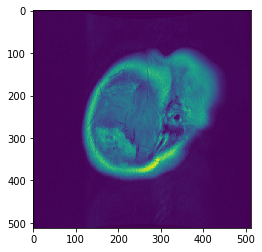

565.mat 298988 b'MATLAB 7.3'
566.mat 315504 b'MATLAB 7.3'
567.mat 322836 b'MATLAB 7.3'
568.mat 328352 b'MATLAB 7.3'
569.mat 344170 b'MATLAB 7.3'
57.mat 274396 b'MATLAB 7.3'
570.mat 341018 b'MATLAB 7.3'
571.mat 333525 b'MATLAB 7.3'
572.mat 329603 b'MATLAB 7.3'


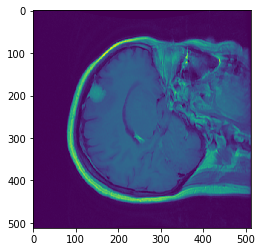

573.mat 317719 b'MATLAB 7.3'
574.mat 322820 b'MATLAB 7.3'
575.mat 325927 b'MATLAB 7.3'
576.mat 332379 b'MATLAB 7.3'
577.mat 279145 b'MATLAB 7.3'


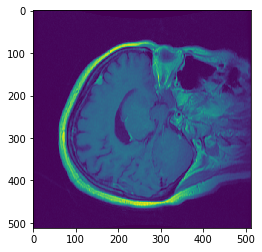

578.mat 282319 b'MATLAB 7.3'
579.mat 310862 b'MATLAB 7.3'
58.mat 258244 b'MATLAB 7.3'
580.mat 325903 b'MATLAB 7.3'
581.mat 327529 b'MATLAB 7.3'
582.mat 334762 b'MATLAB 7.3'
583.mat 339348 b'MATLAB 7.3'
584.mat 252591 b'MATLAB 7.3'
585.mat 239940 b'MATLAB 7.3'
586.mat 336190 b'MATLAB 7.3'
587.mat 332624 b'MATLAB 7.3'


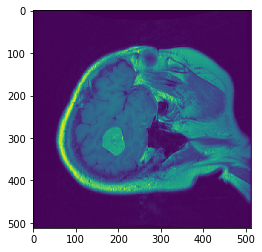

588.mat 326240 b'MATLAB 7.3'
589.mat 334598 b'MATLAB 7.3'
59.mat 304390 b'MATLAB 7.3'
590.mat 331735 b'MATLAB 7.3'
591.mat 319103 b'MATLAB 7.3'


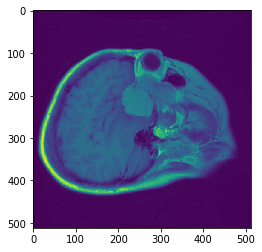

592.mat 304791 b'MATLAB 7.3'
593.mat 316410 b'MATLAB 7.3'
594.mat 320625 b'MATLAB 7.3'
595.mat 329070 b'MATLAB 7.3'


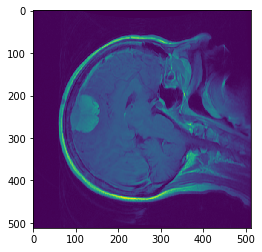

596.mat 298071 b'MATLAB 7.3'
597.mat 272184 b'MATLAB 7.3'
598.mat 274262 b'MATLAB 7.3'
599.mat 351923 b'MATLAB 7.3'
6.mat 292103 b'MATLAB 7.3'
60.mat 262968 b'MATLAB 7.3'
600.mat 359909 b'MATLAB 7.3'
601.mat 363777 b'MATLAB 7.3'
602.mat 366129 b'MATLAB 7.3'
603.mat 296051 b'MATLAB 7.3'
604.mat 301866 b'MATLAB 7.3'
605.mat 308097 b'MATLAB 7.3'
606.mat 331911 b'MATLAB 7.3'
607.mat 338505 b'MATLAB 7.3'
608.mat 344363 b'MATLAB 7.3'
609.mat 345065 b'MATLAB 7.3'
61.mat 258684 b'MATLAB 7.3'
610.mat 338255 b'MATLAB 7.3'
611.mat 335691 b'MATLAB 7.3'
612.mat 330292 b'MATLAB 7.3'
613.mat 324646 b'MATLAB 7.3'
614.mat 313719 b'MATLAB 7.3'
615.mat 322015 b'MATLAB 7.3'
616.mat 332389 b'MATLAB 7.3'


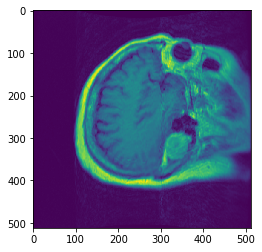

617.mat 337126 b'MATLAB 7.3'
618.mat 342518 b'MATLAB 7.3'
619.mat 251587 b'MATLAB 7.3'
62.mat 262750 b'MATLAB 7.3'
620.mat 258903 b'MATLAB 7.3'
621.mat 283571 b'MATLAB 7.3'
622.mat 280629 b'MATLAB 7.3'
623.mat 276471 b'MATLAB 7.3'
624.mat 272791 b'MATLAB 7.3'
625.mat 323892 b'MATLAB 7.3'
626.mat 326901 b'MATLAB 7.3'
627.mat 333143 b'MATLAB 7.3'
628.mat 337243 b'MATLAB 7.3'
629.mat 338812 b'MATLAB 7.3'
63.mat 260702 b'MATLAB 7.3'
630.mat 332911 b'MATLAB 7.3'
631.mat 339292 b'MATLAB 7.3'
632.mat 343780 b'MATLAB 7.3'
633.mat 347908 b'MATLAB 7.3'
634.mat 350031 b'MATLAB 7.3'
635.mat 275938 b'MATLAB 7.3'
636.mat 263528 b'MATLAB 7.3'
637.mat 247622 b'MATLAB 7.3'
638.mat 227871 b'MATLAB 7.3'
639.mat 329950 b'MATLAB 7.3'
64.mat 256800 b'MATLAB 7.3'
640.mat 278456 b'MATLAB 7.3'
641.mat 283412 b'MATLAB 7.3'
642.mat 313422 b'MATLAB 7.3'
643.mat 316191 b'MATLAB 7.3'
644.mat 320280 b'MATLAB 7.3'
645.mat 323491 b'MATLAB 7.3'
646.mat 324521 b'MATLAB 7.3'
647.mat 332826 b'MATLAB 7.3'
648.mat 263416 b'

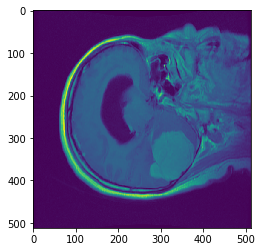

662.mat 282435 b'MATLAB 7.3'
663.mat 277535 b'MATLAB 7.3'
664.mat 320224 b'MATLAB 7.3'
665.mat 320528 b'MATLAB 7.3'
666.mat 325708 b'MATLAB 7.3'
667.mat 331109 b'MATLAB 7.3'
668.mat 341125 b'MATLAB 7.3'
669.mat 344458 b'MATLAB 7.3'
67.mat 272793 b'MATLAB 7.3'
670.mat 345579 b'MATLAB 7.3'
671.mat 346234 b'MATLAB 7.3'
672.mat 348373 b'MATLAB 7.3'
673.mat 287911 b'MATLAB 7.3'
674.mat 345235 b'MATLAB 7.3'
675.mat 320869 b'MATLAB 7.3'
676.mat 324726 b'MATLAB 7.3'
677.mat 328975 b'MATLAB 7.3'
678.mat 332244 b'MATLAB 7.3'
679.mat 335810 b'MATLAB 7.3'
68.mat 271358 b'MATLAB 7.3'
680.mat 321585 b'MATLAB 7.3'
681.mat 329339 b'MATLAB 7.3'
682.mat 332621 b'MATLAB 7.3'
683.mat 334341 b'MATLAB 7.3'
684.mat 336200 b'MATLAB 7.3'
685.mat 340578 b'MATLAB 7.3'
686.mat 324330 b'MATLAB 7.3'
687.mat 327178 b'MATLAB 7.3'
688.mat 339654 b'MATLAB 7.3'
689.mat 336481 b'MATLAB 7.3'
69.mat 267392 b'MATLAB 7.3'
690.mat 336380 b'MATLAB 7.3'
691.mat 332939 b'MATLAB 7.3'
692.mat 329763 b'MATLAB 7.3'
693.mat 287039 b'

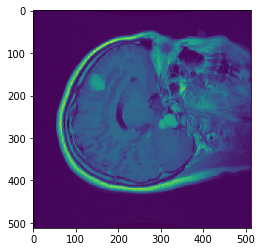

694.mat 292171 b'MATLAB 7.3'
695.mat 292975 b'MATLAB 7.3'
696.mat 341157 b'MATLAB 7.3'
697.mat 348504 b'MATLAB 7.3'
698.mat 343735 b'MATLAB 7.3'
699.mat 341246 b'MATLAB 7.3'
7.mat 290045 b'MATLAB 7.3'
70.mat 265442 b'MATLAB 7.3'
700.mat 337005 b'MATLAB 7.3'
701.mat 333287 b'MATLAB 7.3'
702.mat 321037 b'MATLAB 7.3'
703.mat 280108 b'MATLAB 7.3'
704.mat 280436 b'MATLAB 7.3'
705.mat 278292 b'MATLAB 7.3'


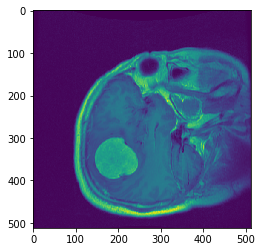

706.mat 275122 b'MATLAB 7.3'
707.mat 270214 b'MATLAB 7.3'
708.mat 263231 b'MATLAB 7.3'
709.mat 303500 b'MATLAB 7.3'
71.mat 259874 b'MATLAB 7.3'
710.mat 302010 b'MATLAB 7.3'
711.mat 300974 b'MATLAB 7.3'
712.mat 287482 b'MATLAB 7.3'
713.mat 289423 b'MATLAB 7.3'


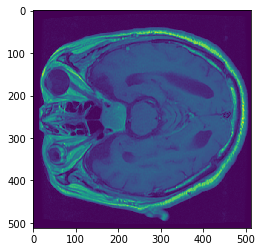

714.mat 289706 b'MATLAB 7.3'
715.mat 273635 b'MATLAB 7.3'
716.mat 271566 b'MATLAB 7.3'
717.mat 269073 b'MATLAB 7.3'
718.mat 257022 b'MATLAB 7.3'
719.mat 258875 b'MATLAB 7.3'
72.mat 259662 b'MATLAB 7.3'
720.mat 257038 b'MATLAB 7.3'
721.mat 255468 b'MATLAB 7.3'
722.mat 277501 b'MATLAB 7.3'


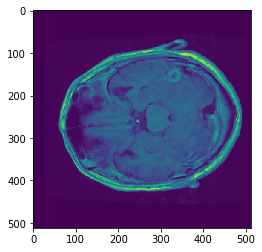

723.mat 275914 b'MATLAB 7.3'
724.mat 271763 b'MATLAB 7.3'
725.mat 258544 b'MATLAB 7.3'
726.mat 258219 b'MATLAB 7.3'
727.mat 257046 b'MATLAB 7.3'
728.mat 256859 b'MATLAB 7.3'
729.mat 279539 b'MATLAB 7.3'
73.mat 267472 b'MATLAB 7.3'
730.mat 278452 b'MATLAB 7.3'
731.mat 279921 b'MATLAB 7.3'
732.mat 278193 b'MATLAB 7.3'
733.mat 276325 b'MATLAB 7.3'
734.mat 271876 b'MATLAB 7.3'
735.mat 265098 b'MATLAB 7.3'
736.mat 262403 b'MATLAB 7.3'
737.mat 259367 b'MATLAB 7.3'
738.mat 254176 b'MATLAB 7.3'
739.mat 247592 b'MATLAB 7.3'


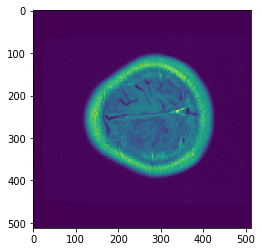

74.mat 265789 b'MATLAB 7.3'
740.mat 279506 b'MATLAB 7.3'
741.mat 274720 b'MATLAB 7.3'
742.mat 273946 b'MATLAB 7.3'
743.mat 273847 b'MATLAB 7.3'
744.mat 272114 b'MATLAB 7.3'
745.mat 271436 b'MATLAB 7.3'
746.mat 268598 b'MATLAB 7.3'
747.mat 283772 b'MATLAB 7.3'
748.mat 288505 b'MATLAB 7.3'
749.mat 293158 b'MATLAB 7.3'
75.mat 263204 b'MATLAB 7.3'
750.mat 299256 b'MATLAB 7.3'
751.mat 301227 b'MATLAB 7.3'
752.mat 304253 b'MATLAB 7.3'
753.mat 286331 b'MATLAB 7.3'
754.mat 282867 b'MATLAB 7.3'
755.mat 277386 b'MATLAB 7.3'
756.mat 270188 b'MATLAB 7.3'
757.mat 261203 b'MATLAB 7.3'
758.mat 253483 b'MATLAB 7.3'
759.mat 246026 b'MATLAB 7.3'
76.mat 259641 b'MATLAB 7.3'
760.mat 237088 b'MATLAB 7.3'
761.mat 311424 b'MATLAB 7.3'
762.mat 311395 b'MATLAB 7.3'
763.mat 308093 b'MATLAB 7.3'
764.mat 289365 b'MATLAB 7.3'
765.mat 293938 b'MATLAB 7.3'
766.mat 297012 b'MATLAB 7.3'
77.mat 256103 b'MATLAB 7.3'
78.mat 252007 b'MATLAB 7.3'
79.mat 245844 b'MATLAB 7.3'
8.mat 288838 b'MATLAB 7.3'
80.mat 269693 b'MATLAB

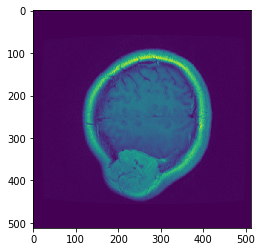

86.mat 249975 b'MATLAB 7.3'


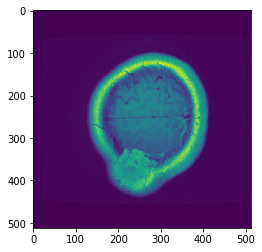

87.mat 282554 b'MATLAB 7.3'
88.mat 281284 b'MATLAB 7.3'
89.mat 279554 b'MATLAB 7.3'
9.mat 245387 b'MATLAB 7.3'
90.mat 277965 b'MATLAB 7.3'
91.mat 233649 b'MATLAB 7.3'
92.mat 220500 b'MATLAB 7.3'
93.mat 275672 b'MATLAB 7.3'
94.mat 272014 b'MATLAB 7.3'
95.mat 267417 b'MATLAB 7.3'
96.mat 266631 b'MATLAB 7.3'
97.mat 266883 b'MATLAB 7.3'
98.mat 263948 b'MATLAB 7.3'
99.mat 293088 b'MATLAB 7.3'


In [15]:
for root, dirs, files in os.walk("/content/drive/My Drive/1512427/", topdown = False):
   #print(root,dirs,files)
   for f in files:
     if ".zip" in f:
        file = zipfile.ZipFile(root+f, "r")
        for name in file.namelist():
          data = file.read(name)
          print (name, len(data), repr(data[:10]))
          file.extract(name,".")
          #print(return_imageInfo_from_mat_file(name))
          if np.random.randint(1000) < np.random.randint(100):
            plt.imshow( return_imageInfo_from_mat_file(name)[0])
            plt.show()
          #break
        break
